{'Annual return %': 27.9, 'Sharpe': 1.85, 'Sortina': 2.12, 'Winning months %': 73.0, 'Time in market %': 26.0, 'Average profit %': 0.74, 'Average duration per trade': '3d18h56m', 'Profit factor': 1.06, 'Trades/month': 2.0}


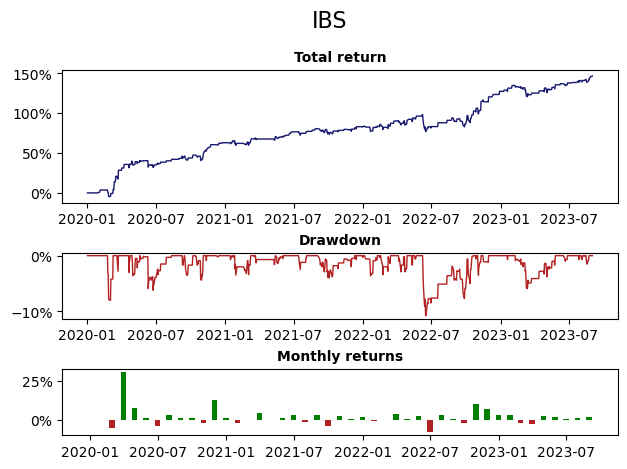

In [1]:
from event import OrderEvent
from strategy import Strategy
from backtest import Backtest
from datetime import date
from data_handler import HistoricalPolygonDataHandler
from broker import SimulatedBroker
from portfolio import StandardPortfolio


class InternalBarStrengthStrategy(Strategy):
    def __init__(self, events, data_handler, portfolio, symbol="SPY"):
        self.events = events
        self.data_handler = data_handler  # To retrieve the data
        self.portfolio = portfolio  # To retrieve portfolio stats (equity, cash)

        self.data_handler.load_data(
            symbol,
            start_date=date(2020, 1, 1),
            end_date=date(2023, 9, 1),
            timeframe="daily",
            extended_hours=False,
        )

        self.in_market = False

    def calculate_signals(self):
        current_cash = self.portfolio.current_cash

        latest_bar = self.data_handler.get_latest_bars("SPY", N=1).iloc[-1]
        ibs = (latest_bar.close - latest_bar.low) / (latest_bar.high - latest_bar.low)
        if not self.in_market and ibs <= 0.2:
            stocks_to_buy = int(current_cash / latest_bar.close)
            order = OrderEvent(self.data_handler.current_time, "SPY", "BUY", stocks_to_buy)
            self.events.put(order)
            self.in_market = True

        elif self.in_market and ibs >= 0.8:
            stocks_to_sell = self.portfolio.current_positions["SPY"]
            order = OrderEvent(self.data_handler.current_time, "SPY", "SELL", stocks_to_sell)
            self.events.put(order)
            self.in_market = False

    def on_backtest_end(self):
        # Liquidate everything
        for symbol, position in self.portfolio.current_positions.items():
            if position != 0:
                action = "SELL" if position > 0 else "BUY"
                order = OrderEvent(
                    self.data_handler.current_time,
                    symbol,
                    side=action,
                    quantity=position,
                )
                self.events.put(order)

    def on_market_close(self):
        pass


backtest = Backtest(
    name="ibs",
    initial_capital=10000,
    start_date=date(2020, 1, 1),
    end_date=date(2023, 9, 1),
    timeframe="daily",
    extended_hours=False,
    strategy=InternalBarStrengthStrategy,
    data_handler=HistoricalPolygonDataHandler,
    broker=SimulatedBroker,
    portfolio=StandardPortfolio,
)

backtest.run()